<a href="https://colab.research.google.com/github/littlejacinthe/Style_Transfer/blob/main/Style_Transfer_STN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip uninstall tensorflow

Uninstalling tensorflow-2.5.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.5.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.5.0


In [2]:
! pip install tensorflow-gpu==1.14.0

     |████████████████████████████████| 377.1MB 46kB/s 
     |████████████████████████████████| 491kB 28.9MB/s 
     |████████████████████████████████| 51kB 2.9MB/s 
     |████████████████████████████████| 3.2MB 35.4MB/s 
  Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Found existing installation: tensorboard 2.5.0
    Uninstalling tensorboard-2.5.0:
      Successfully uninstalled tensorboard-2.5.0


In [3]:
import tensorflow as tf
import librosa
import os
from IPython.display import Audio, display
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [4]:
# Reads wav file and produces spectrum
N_FFT = 2048
def read_audio_spectum(filename):
    x, fs = librosa.load(filename) 
    max_len = fs * 10
    sig = x[:max_len]
    S = librosa.stft(sig, N_FFT) # short fourier transform produces spectrogram
    p = np.angle(S) # The counterclockwise angle from the positive real axis on the complex plane in the range (-pi, pi], with dtype as numpy.float64.
    S = np.log1p(np.abs(S[:,:430]))  
    # Log1p : Return the natural logarithm of one plus the input array, element-wise.
    # Abs : Calculate the absolute value element-wise.
    return S, fs

In [5]:
CONTENT_FILENAME = '/content/classical_03.wav'
STYLE_FILENAME = '/content/jazz_05.wav'

In [6]:
display(Audio(CONTENT_FILENAME))
display(Audio(STYLE_FILENAME))

In [7]:
# make spectrograms for content and style
a_content, fs = read_audio_spectum(STYLE_FILENAME)
a_style, fs = read_audio_spectum(CONTENT_FILENAME)

N_SAMPLES = a_content.shape[1]
N_CHANNELS = a_content.shape[0]
a_style = a_style[:N_CHANNELS, :N_SAMPLES] # make sure content and style are the same shape [N_CHANNELS, N_SAMPLES]

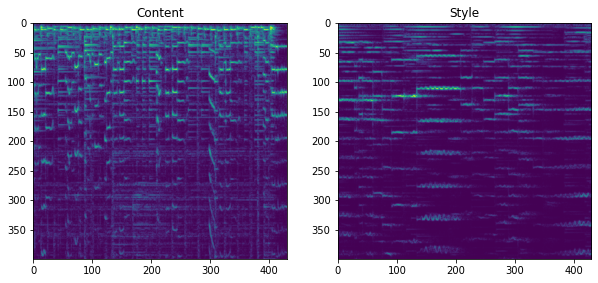

In [8]:
#plot spectrograms 
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Content')
plt.imshow(a_content[:400,:])
plt.subplot(1, 2, 2)
plt.title('Style')
plt.imshow(a_style[:400,:])
plt.show()

In [9]:
N_FILTERS = 4096

# spectrogram input
a_content_tf = np.ascontiguousarray(a_content.T[None,None,:,:]) #contiguous array in memory --> transposed array, added 2 dim (one for batch)
a_style_tf = np.ascontiguousarray(a_style.T[None,None,:,:])


# filter shape is "[filter_height, filter_width, in_channels, out_channels]" --> this will generate random weights for the model
std = np.sqrt(2) * np.sqrt(2.0 / ((N_CHANNELS + N_FILTERS) * 11))
kernel = np.random.randn(1, 11, N_CHANNELS, N_FILTERS)*std
    
g = tf.Graph()
with g.as_default(), g.device('/cpu:0'), tf.Session() as sess:
    # data shape is "[batch, in_height, in_width, in_channels]",
    x = tf.placeholder('float32', [1,1,N_SAMPLES,N_CHANNELS], name="x") # x is the input variable

    kernel_tf = tf.constant(kernel, name="kernel", dtype='float32') # weights
    conv = tf.nn.conv2d(
        x,
        kernel_tf,
        strides=[1, 1, 1, 1],
        padding="VALID",
        name="conv")
    
    net = tf.nn.relu(conv)

    content_features = net.eval(feed_dict={x: a_content_tf}) # feed the content spectrogram to the model to obtain content features

    style_features = net.eval(feed_dict={x: a_style_tf}) # feed the style spectrogram to the model 
    features = np.reshape(style_features, (-1, N_FILTERS)) 
    style_gram = np.matmul(features.T, features) / N_SAMPLES # the gram matrix extract style features 
    # matmul : matrix product of two arrays

In [10]:
with tf.Graph().as_default():
  x = tf.Variable(content_features) # using content features as input
  
  # finishing our localization network : after one convolution from the previous cell, flatten and use a one dense layer
  flat = tf.compat.v1.layers.flatten(inputs=x)
  dense = tf.compat.v1.layers.dense(inputs=flat, units=6)

  
  with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())

        result = dense.eval()

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [22]:
def spatial_transformer_network(input_fmap, theta, out_dims=None, **kwargs):
    """
    Spatial Transformer Network layer implementation as described in [1].
    The layer is composed of 3 elements:
    - localization_net: takes the original image as input and outputs
      the parameters of the affine transformation that should be applied
      to the input image.
    - affine_grid_generator: generates a grid of (x,y) coordinates that
      correspond to a set of points where the input should be sampled
      to produce the transformed output.
    - bilinear_sampler: takes as input the original image and the grid
      and produces the output image using bilinear interpolation.
    Input
    -----
    - input_fmap: output of the previous layer. Can be input if spatial
      transformer layer is at the beginning of architecture. Should be
      a tensor of shape (B, H, W, C).
    - theta: affine transform tensor of shape (B, 6). Permits cropping,
      translation and isotropic scaling. Initialize to identity matrix.
      It is the output of the localization network.
    Returns
    -------
    - out_fmap: transformed input feature map. Tensor of size (B, H, W, C).
    Notes
    -----
    [1]: 'Spatial Transformer Networks', Jaderberg et. al,
         (https://arxiv.org/abs/1506.02025)
    """
    # grab input dimensions
    B = tf.shape(input_fmap)[0]
    H = tf.shape(input_fmap)[1]
    W = tf.shape(input_fmap)[2]

    # reshape theta to (B, 2, 3)
    theta = tf.reshape(theta, [B, 2, 3])

    # generate grids of same size or upsample/downsample if specified
    if out_dims:
        out_H = out_dims[0]
        out_W = out_dims[1]
        batch_grids = affine_grid_generator(out_H, out_W, theta)
    else:
        batch_grids = affine_grid_generator(H, W, theta)

    x_s = batch_grids[:, 0, :, :]
    y_s = batch_grids[:, 1, :, :]

    # sample input with grid to get output
    out_fmap = bilinear_sampler(input_fmap, x_s, y_s)

    return out_fmap


def get_pixel_value(img, x, y):
    """
    Utility function to get pixel value for coordinate
    vectors x and y from a  4D tensor image.
    Input
    -----
    - img: tensor of shape (B, H, W, C)
    - x: flattened tensor of shape (B*H*W,)
    - y: flattened tensor of shape (B*H*W,)
    Returns
    -------
    - output: tensor of shape (B, H, W, C)
    """
    shape = tf.shape(x)
    batch_size = shape[0]
    height = shape[1]
    width = shape[2]

    batch_idx = tf.range(0, batch_size)
    batch_idx = tf.reshape(batch_idx, (batch_size, 1, 1))
    b = tf.tile(batch_idx, (1, height, width))

    indices = tf.stack([b, y, x], 3)

    return tf.gather_nd(img, indices)


def affine_grid_generator(height, width, theta):
    """
    This function returns a sampling grid, which when
    used with the bilinear sampler on the input feature
    map, will create an output feature map that is an
    affine transformation [1] of the input feature map.
    Input
    -----
    - height: desired height of grid/output. Used
      to downsample or upsample.
    - width: desired width of grid/output. Used
      to downsample or upsample.
    - theta: affine transform matrices of shape (num_batch, 2, 3).
      For each image in the batch, we have 6 theta parameters of
      the form (2x3) that define the affine transformation T.
    Returns
    -------
    - normalized grid (-1, 1) of shape (num_batch, 2, H, W).
      The 2nd dimension has 2 components: (x, y) which are the
      sampling points of the original image for each point in the
      target image.
    Note
    ----
    [1]: the affine transformation allows cropping, translation,
         and isotropic scaling.
    """
    num_batch = tf.shape(theta)[0]

    # create normalized 2D grid
    x = tf.linspace(-1.0, 1.0, width)
    y = tf.linspace(-1.0, 1.0, height)
    x_t, y_t = tf.meshgrid(x, y)

    # flatten
    x_t_flat = tf.reshape(x_t, [-1])
    y_t_flat = tf.reshape(y_t, [-1])

    # reshape to [x_t, y_t , 1] - (homogeneous form)
    ones = tf.ones_like(x_t_flat)
    sampling_grid = tf.stack([x_t_flat, y_t_flat, ones])

    # repeat grid num_batch times
    sampling_grid = tf.expand_dims(sampling_grid, axis=0)
    sampling_grid = tf.tile(sampling_grid, tf.stack([num_batch, 1, 1]))

    # cast to float32 (required for matmul)
    theta = tf.cast(theta, 'float32')
    sampling_grid = tf.cast(sampling_grid, 'float32')

    # transform the sampling grid - batch multiply
    batch_grids = tf.matmul(theta, sampling_grid)
    # batch grid has shape (num_batch, 2, H*W)

    # reshape to (num_batch, H, W, 2)
    batch_grids = tf.reshape(batch_grids, [num_batch, 2, height, width])

    return batch_grids


def bilinear_sampler(img, x, y):
    """
    Performs bilinear sampling of the input images according to the
    normalized coordinates provided by the sampling grid. Note that
    the sampling is done identically for each channel of the input.
    To test if the function works properly, output image should be
    identical to input image when theta is initialized to identity
    transform.
    Input
    -----
    - img: batch of images in (B, H, W, C) layout.
    - grid: x, y which is the output of affine_grid_generator.
    Returns
    -------
    - out: interpolated images according to grids. Same size as grid.
    """
    H = tf.shape(img)[1]
    W = tf.shape(img)[2]
    max_y = tf.cast(H - 1, 'int32')
    max_x = tf.cast(W - 1, 'int32')
    zero = tf.zeros([], dtype='int32')

    # rescale x and y to [0, W-1/H-1]
    x = tf.cast(x, 'float32')
    y = tf.cast(y, 'float32')
    x = 0.5 * ((x + 1.0) * tf.cast(max_x-1, 'float32'))
    y = 0.5 * ((y + 1.0) * tf.cast(max_y-1, 'float32'))

    # grab 4 nearest corner points for each (x_i, y_i)
    x0 = tf.cast(tf.floor(x), 'int32')
    x1 = x0 + 1
    y0 = tf.cast(tf.floor(y), 'int32')
    y1 = y0 + 1

    # clip to range [0, H-1/W-1] to not violate img boundaries
    x0 = tf.clip_by_value(x0, zero, max_x)
    x1 = tf.clip_by_value(x1, zero, max_x)
    y0 = tf.clip_by_value(y0, zero, max_y)
    y1 = tf.clip_by_value(y1, zero, max_y)

    # get pixel value at corner coords
    Ia = get_pixel_value(img, x0, y0)
    Ib = get_pixel_value(img, x0, y1)
    Ic = get_pixel_value(img, x1, y0)
    Id = get_pixel_value(img, x1, y1)

    # recast as float for delta calculation
    x0 = tf.cast(x0, 'float32')
    x1 = tf.cast(x1, 'float32')
    y0 = tf.cast(y0, 'float32')
    y1 = tf.cast(y1, 'float32')

    # calculate deltas
    wa = (x1-x) * (y1-y)
    wb = (x1-x) * (y-y0)
    wc = (x-x0) * (y1-y)
    wd = (x-x0) * (y-y0)

    # add dimension for addition
    wa = tf.expand_dims(wa, axis=3)
    wb = tf.expand_dims(wb, axis=3)
    wc = tf.expand_dims(wc, axis=3)
    wd = tf.expand_dims(wd, axis=3)

    # compute output
    out = tf.add_n([wa*Ia, wb*Ib, wc*Ic, wd*Id])

    return out

In [12]:
 # reshape content input to B, H, W, C
content = a_content.reshape([1, 430, 1025, 1])

In [13]:
B, H, W, C = content.shape

In [14]:
# identity transform
theta = np.array([[1., 0, 0], [0, 1., 0]])

In [ ]:
# rotation transform

def deg2rad(x):
    """Converts an angle in degrees to radians."""
    return (x * np.pi) / 180

# initialize affine transform tensor `theta`
degree = 45
theta = np.array([
    [np.cos(deg2rad(degree)), -np.sin(deg2rad(degree)), 0], 
    [np.sin(deg2rad(degree)), np.cos(deg2rad(degree)), 0]
])

In [24]:
x = tf.placeholder(tf.float32, [None, H, W, C])

with tf.variable_scope('spatial_transformer'):
    theta = theta.astype('float32')
    theta = theta.flatten()

    # define loc net weight and bias
    loc_in = H*W*C
    loc_out = 6
    W_loc = tf.Variable(tf.zeros([loc_in, loc_out]), name='W_loc')
    b_loc = tf.Variable(initial_value=theta, name='b_loc')
    
    # tie everything together
    fc_loc = tf.matmul(tf.zeros([B, loc_in]), W_loc) + b_loc
    h_trans = spatial_transformer_network(x, result) # STN(spectrogram input, theta parameters from the Dense layer above)

In [25]:
# run session
sess = tf.Session()
sess.run(tf.global_variables_initializer())
y = sess.run(h_trans, feed_dict={x: content}) # feed content input to the STN
print("y: {}".format(y.shape))

y: (1, 430, 1025, 1)


In [26]:
content_stn = y.reshape([1, 1, 430, 1025]) # reshape to have a proper input for the rest of the network

In [27]:
from sys import stderr

ALPHA= 0.002
learning_rate= 0.01
iterations = 200

result = None

with tf.Graph().as_default():

    # Build graph with variable input
    #x = tf.Variable(np.zeros([1,1,N_SAMPLES,N_CHANNELS], dtype=np.float32), name="x")
  #  x = tf.Variable(np.random.randn(1,1,N_SAMPLES,N_CHANNELS).astype(np.float32)*1e-3, name="x") #random noise input

   # Ulyanov uses a random input to check the correlation with the features, we use the STN output
    x = tf.Variable(content_stn)
    kernel_tf = tf.constant(kernel, name="kernel", dtype='float32') # weights
    conv = tf.nn.conv2d(
        x,
        kernel_tf,
        strides=[1, 1, 1, 1],
        padding="VALID",
        name="conv")
    
    net = tf.nn.relu(conv)
   
    # the content loss then compares the content features extracted after one convolution ("content_features") 
    # and the features at the end of the network, passed through the STN then one convolution ("net")
    content_loss = ALPHA * 2 * tf.nn.l2_loss(
            net - content_features)
    #tf L2 loss : Computes half the L2 norm of a tensor without the sqrt --> so * 2 is for full l2 norm
    # L2 norm is a standard method to compute the length of a vector in Euclidean space

    style_loss = 0

    _, height, width, number = map(lambda i: i.value, net.get_shape())

    size = height * width * number
    feats = tf.reshape(net, (-1, number))
    gram = tf.matmul(tf.transpose(feats), feats)  / N_SAMPLES # making a gram of the net output

    #the style loss compares the style gram after one convolution ("style_gram")
    # and the gram made after the STN output was passed through another convolution ("net")
    style_loss = 2 * tf.nn.l2_loss(gram - style_gram) 

     # Overall loss
    loss = content_loss + style_loss

    opt = tf.contrib.opt.ScipyOptimizerInterface(
          loss, method='L-BFGS-B', options={'maxiter': 300}) # Minimize a scalar function of one or more variables using the L-BFGS-B algorithm.
        
    # Optimization
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
       
        print('Started optimization.')
        opt.minimize(sess)
    
        print('Final loss:', loss.eval())
        result = x.eval()

Started optimization.
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 252.894562
  Number of iterations: 300
  Number of functions evaluations: 307
Final loss: 252.89456


In [28]:
import soundfile

In [29]:
# audio reconstruction

a = np.zeros_like(a_content) # array of 0s 
a[:N_CHANNELS,:] = np.exp(result[0,0].T) - 1 # Calculate the exponential of all elements in the input array.

# This code is supposed to do phase reconstruction
p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi # Return random floats in the half-open interval [0.0, 1.0).
for i in range(500):

    S = a * np.exp(1j*p) 
    x = librosa.istft(S)
    p = np.angle(librosa.stft(x, 2048)) # N_FFT = 2048


OUTPUT_FILENAME = 'out.wav'
soundfile.write(OUTPUT_FILENAME, x, fs)

In [31]:
print(OUTPUT_FILENAME)
display(Audio(OUTPUT_FILENAME)) 

out.wav


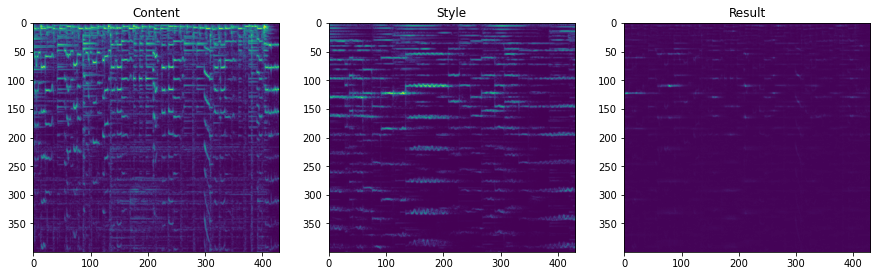

In [30]:
# plot spectrograms

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title('Content')
plt.imshow(a_content[:400,:])
plt.subplot(1,3,2)
plt.title('Style')
plt.imshow(a_style[:400,:])
plt.subplot(1,3,3)
plt.title('Result')
plt.imshow(a[:400,:])
plt.show()